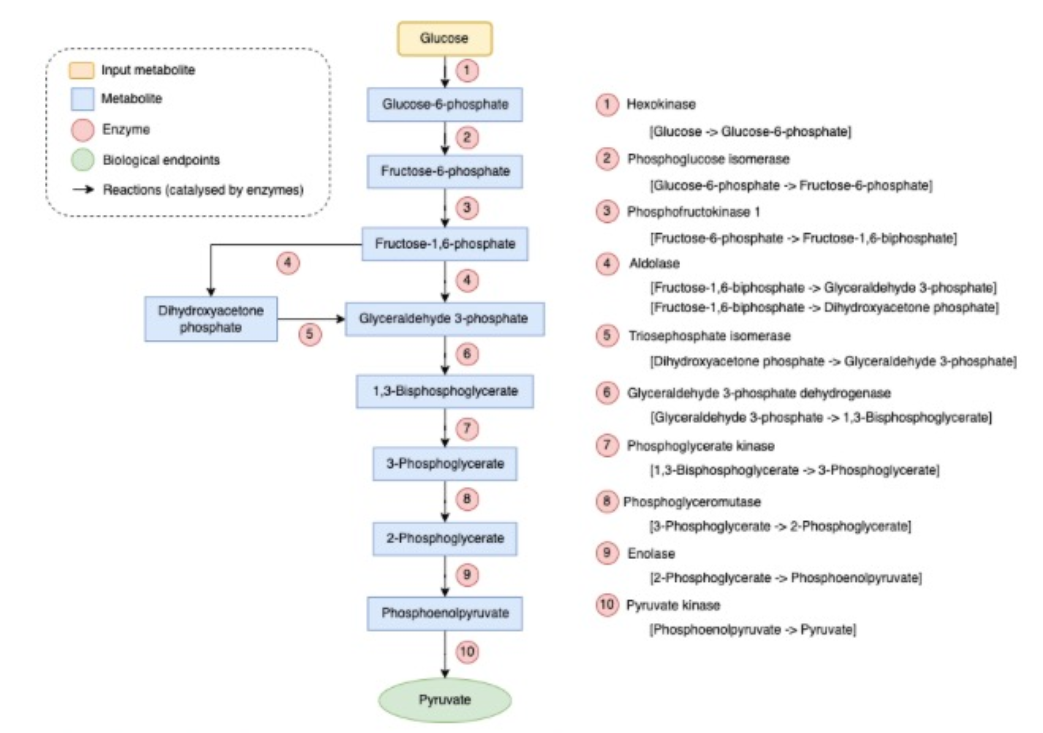
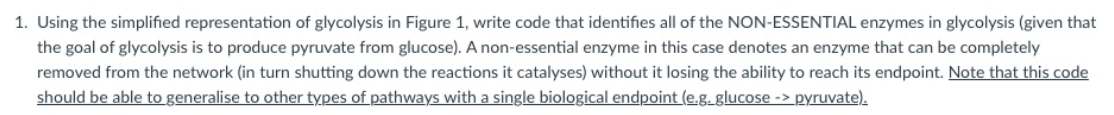

Graph info
	Metabolytes
		Glucose [c]
		Glucose-6-phosphate [c]
		ADP-Glucose [c]
		Fructose-6-phosphate [c]
		6-Phosphogluconolactone [c]
		Fructose-1-6-phosphate [c]
		Erythrose-4-phosphate [c]
		Seduheptulose-7-phosphate [c]
		Glyceraldehyde 3-phosphate [c]
		Xylulose-5-phosphate [c]
		Dihydroxyacetone phosphate [c]
		1-3-Bisphosphoglycerate [c]
		Ribose-5-phosphate [c]
		3-Phosphoglycerate [c]
		2-Phosphoglycerate [c]
		Serine
		Cysteine
		Glycine
		Phosphoenolpyruvate [c]
		Pyruvate [c]
		Oxaloacetate [m]
		Lactate [c]
		Acetyl CoA [c]
		Alanine
		Pyruvate [m]
		Citrate [m]
		Fatty acids
		Isocitrate [m]
		Citrate [c]
		2-Oxoglutarate [m]
		Succinate [m]
		2-Oxoglutarate [c]
		Glutamine
		Glutamate
		Fumarate [m]
		Malate [m]
		Aspartate
		Asparagine
		Isocitrate [c]
		6-Phosphogluconate [c]
		Ribulose-5-phosphate [c]
		Nucleotides
		Glycogen [c]
	Enzymes
		Enzyme1
		Enzyme33
		Enzyme2
		Enzyme26
		Enzyme3
		TALDO
		TKT
		Enzyme4
		Enzyme5
		Enzyme6
		Enzyme7
		Enzyme8
		Enzyme9
	

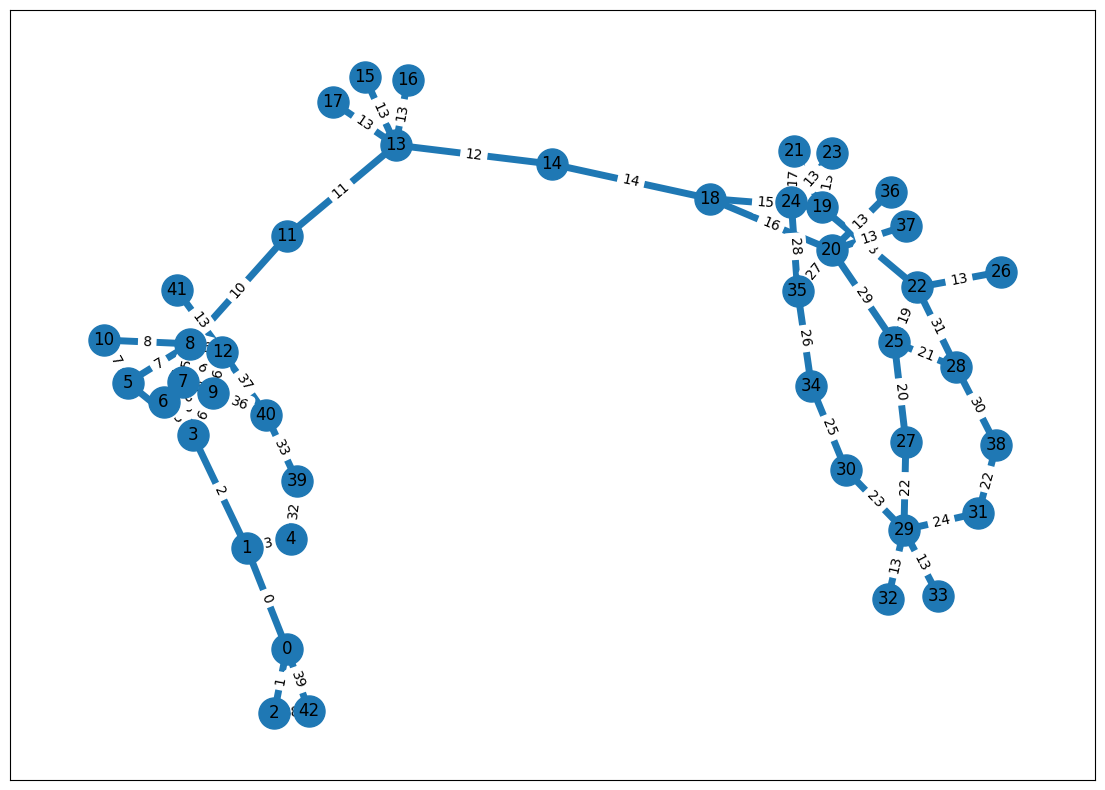

In [21]:
import csv
import networkx as nx
import matplotlib.pyplot as plt


def read_graph(filename):
    # Metabolyte -> (Metabolyte,Enzyme)
    graph = {}
    with open(filename, "r") as f:
        reader = csv.reader(f)
        next(reader)  # skip header

        for metabolyte_from, metabolyte_to, enzyme in reader:
            if metabolyte_from in graph:
                graph[metabolyte_from].append((metabolyte_to, enzyme))
            else:
                graph[metabolyte_from] = [(metabolyte_to, enzyme)]

    return graph


def graph_to_nx(graph) -> None:
    # Metabolyte -> (Metabolyte,Enzyme)
    node_idx_lut = {}
    edge_idx_lut = {}
    nodes = []
    edges = []

    nx_graph = nx.Graph()
    for metabolyte_from, links in graph.items():
        for metabolyte_to, enzyme in links:
            if metabolyte_from in node_idx_lut:
                node_idx_from = node_idx_lut[metabolyte_from]
            else:
                node_idx_from = len(nodes)
                nodes.append(metabolyte_from)
                node_idx_lut[metabolyte_from] = node_idx_from
                nx_graph.add_node(node_idx_from)

            if metabolyte_to in node_idx_lut:
                node_idx_to = node_idx_lut[metabolyte_to]
            else:
                node_idx_to = len(nodes)
                nodes.append(metabolyte_to)
                node_idx_lut[metabolyte_to] = node_idx_to
                nx_graph.add_node(node_idx_to)

            if enzyme in edge_idx_lut:
                edge_idx = edge_idx_lut[enzyme]
            else:
                edge_idx = len(edges)
                edges.append(enzyme)
                edge_idx_lut[enzyme] = edge_idx

            nx_graph.add_edge(node_idx_from, node_idx_to, index=edge_idx)

    return nx_graph, node_idx_lut, edge_idx_lut, nodes, edges


def draw_graph(
    nx_graph,
    node_pos=None,
    node_color="#1f78b4",
    edge_color=None,
    node_list=None,
    edge_list=None,
    node_size=500,
    edge_width=5.0,
):
    if edge_color is None:
        edge_color = node_color

    if node_pos is None:
        node_pos = nx.layout.spring_layout(nx_graph)

    nx.draw_networkx_nodes(
        nx_graph,
        node_pos,
        node_color=node_color,
        nodelist=node_list,
        node_size=node_size,
    )
    nx.draw_networkx_edges(
        nx_graph,
        node_pos,
        edge_color=edge_color,
        edgelist=edge_list,
        width=edge_width,
    )
    nx.draw_networkx_labels(nx_graph, node_pos)

    if edge_list is None:
        edgelist = nx_graph.edges
    else:
        edgelist = edge_list

    nx.draw_networkx_edge_labels(
        nx_graph,
        node_pos,
        edge_labels={edge: nx_graph.get_edge_data(*edge)["index"] for edge in edgelist},
    )


exercise_option = 1

if exercise_option == 0:
    filename = "example_file.csv"
    start_metabolyte = "Glucose"
    end_metabolytes = ["Pyruvate"]
    show_essential_single = False
    show_nonessential_single = True
    show_all_single = False
    show_essential_merged = False
    figsize=(11, 7)
    print_paths = True
    plot_paths = True


elif exercise_option == 1:
    filename = "example_file2.csv"
    start_metabolyte = "Glucose [c]"
    end_metabolytes = [
        "Nucleotides",
        "Serine",
        "Cysteine",
        "Glycine",
        "Alanine",
        "Fatty acids",
        "Aspartate",
        "Asparagine",
        "Glutamate",
        "Glutamine",
    ]
    show_essential_single = False
    show_nonessential_single = False
    show_all_single = False
    show_essential_merged = True
    figsize=(14, 10)
    print_paths = True
    plot_paths = False


graph = read_graph(filename)
nx_graph, node_idx_lut, edge_idx_lut, nodes, edges = graph_to_nx(graph)
node_pos = nx.layout.spring_layout(nx_graph, seed=69420)

plt.figure(figsize=figsize)
draw_graph(nx_graph, node_pos=node_pos)

print("="*50)
print(f"Graph info")
print("="*50)
print("\tMetabolytes\n\t\t", end='')
print("\n\t\t".join(nodes))
print("\tEnzymes\n\t\t", end='')
print("\n\t\t".join(edges))

In [17]:
import numpy as np

class Path:
    def __init__(self, entries: list[tuple[str, str]] = None) -> None:
        self.entries = entries if (entries is not None) else []
        self.visited = {node for node, _ in entries} if entries else set()

    def add_entry(self, node: str, enzyme: str) -> None:
        self.entries.append((node, enzyme))
        self.visited.add(node)

    @property
    def node_list(self):
        return [node for node, _ in self.entries if node is not None]

    @property
    def edge_list(self):
        return [edge for _, edge in self.entries if edge is not None]


    @property
    def connection_list(self):
        connection_list = {}
        for i in range(len(self.entries) - 1):
            node_from, _ = self.entries[i]
            node_to, edge = self.entries[i+1]
            connection_list[node_from, node_to] = edge
        return connection_list


    def __repr__(self) -> str:
        return repr(self.entries)


def find_all_paths(
    graph: dict[str, tuple[str, str]], start_node: str, end_nodes: set[str]
) -> list[Path]:
    paths = []

    start_path = Path(entries=[(start_node, None)])
    frontier = [start_path]  # Which nodes to visit next

    while frontier:
        path = frontier.pop()
        node, enzyme = path.entries[-1]

        if (
            node in end_nodes
        ):  # If we reach the final node -> add this path to the list of paths
            curr_node, curr_enzyme = node, enzyme
            paths.append(path)
            continue

        if node not in graph:
            continue

        for node_to, enzyme_to in graph[
            node
        ]:  # Go over each possible reaction and create a path that covers that
            if node_to in path.visited:  # Avoid cycles
                continue

            new_path = Path(
                entries=path.entries.copy()
            )  # We have to copy the current path into a new one, since otherwise the object changes in the backtrack.
            new_path.add_entry(node_to, enzyme_to)
            frontier.append(new_path)

    return paths



def show_path_info(all_paths, nx_graph, node_idx_lut, edge_idx_lut, print_paths: bool, plot_paths: bool) -> None:
    if plot_paths:
        plt.figure(figsize=figsize)

    if print_paths:
        print("="*50)
        print("Path information")
        print("="*50)

    for i, path in enumerate(all_paths):
        if print_paths:
            print(f"\tPath number: {i}")
            base_pad = 30
            print(f"{' ' * (base_pad - 10)}Metabolyte{' ' * (base_pad - 6)}Enzyme")
            for node, enzyme in path.entries:
                rep_1 = str(node) if node else ""
                rep_2 = str(enzyme) if enzyme else ""
                padding_1 = ' ' * (base_pad - len(rep_1))
                padding_2 = ' ' * (base_pad - len(rep_2))
                print(f"{padding_1}{rep_1}{padding_2}{rep_2}")

        if plot_paths:
            if (len(all_paths) > 50) and (i % 1000 != 0):
                continue

            node_idx_list = [node_idx_lut[node] for node in path.node_list]
            edge_idx_list = {(node_idx_lut[node_from], node_idx_lut[node_to]): edge_idx_lut[edge] for (node_from, node_to), edge in path.connection_list.items()}
            
            color = [(0.5+0.2*np.cos(1.8*i+3), 0.5+0.2*np.sin(-2.1*i+1), 0.5+0.2*np.sin(4.2*i*0.1+2))]
            draw_graph(nx_graph, node_pos, node_color=color, node_list=node_idx_list, edge_list=edge_idx_list)

all_paths = find_all_paths(graph, start_metabolyte, end_metabolytes)
show_path_info(all_paths, nx_graph, node_idx_lut, edge_idx_lut, print_paths, plot_paths)

Path information
	Path number: 0
                    Metabolyte                        Enzyme
                   Glucose [c]                              
       Glucose-6-phosphate [c]                       Enzyme1
   6-Phosphogluconolactone [c]                      Enzyme26
        6-Phosphogluconate [c]                      Enzyme27
      Ribulose-5-phosphate [c]                      Enzyme28
        Ribose-5-phosphate [c]                      Enzyme30
                   Nucleotides                 PseudoEnzymes
	Path number: 1
                    Metabolyte                        Enzyme
                   Glucose [c]                              
       Glucose-6-phosphate [c]                       Enzyme1
   6-Phosphogluconolactone [c]                      Enzyme26
        6-Phosphogluconate [c]                      Enzyme27
      Ribulose-5-phosphate [c]                      Enzyme28
        Ribose-5-phosphate [c]                      Enzyme30
Glyceraldehyde 3-phosphate [c]      

In [6]:
def group_paths_by_end(paths: list[Path]) -> dict[str, list[Path]]:
    groups = {}
    for path in paths:
        end_node, _ = path.entries[-1]
        if end_node in groups:
            groups[end_node].append(path)
        else:
            groups[end_node] = [path]

    return groups


def find_essential_single_end(enzymes: list[set[str]]) -> set[str]:
    # The essential enzymes to reach one single end are the enzymes that appear in every path, thus the intersection.
    if len(enzymes) == 0:
        return set()

    enzymes_essential = enzymes[0].copy()
    for enzyme in enzymes[1:]:
        enzymes_essential.intersection_update(enzyme)

    return enzymes_essential


def find_all_enzymes_single_end(enzymes: list[set[str]]) -> set[str]:
    if len(enzymes) == 0:
        set()

    enzymes_all = enzymes[0].copy()
    for enzyme in enzymes[1:]:
        enzymes_all.update(enzyme)

    return enzymes_all


def find_nonessential_single_end(
    enzymes_all: set[str], enzymes_essential: set[str]
) -> set[str]:
    enzymes_nonessential = enzymes_all.difference(enzymes_essential)
    return enzymes_nonessential


def find_essential_enzymes(essential_singles: list[set[str]]) -> set[str]:
    # Every essential enzyme is essential in every group, thus we need the union of all essential enzymes.
    if len(essential_singles) == 0:
        return set()

    essential_enzymes = essential_singles[0].copy()
    for enzyme in essential_singles[1:]:
        essential_enzymes.update(enzyme)

    return essential_enzymes


def show_enzyme_info(
    all_paths,
    show_essential_single,
    show_nonessential_single,
    show_all_single,
    show_essential_merged,
):
    path_groups = group_paths_by_end(all_paths)
    path_group_info = {}

    for end, path_group in path_groups.items():
        enzymes = [set(path.edge_list) for path in path_group]
        enzymes_essential = find_essential_single_end(enzymes)
        enzymes_all = find_all_enzymes_single_end(enzymes)
        enzymes_nonessential = find_nonessential_single_end(
            enzymes_all, enzymes_essential
        )

        path_group_info[end] = {
            "essential": enzymes_essential,
            "nonessential": enzymes_nonessential,
            "all": enzymes_all,
        }

    all_essential_enzymes = find_essential_enzymes(
        [info["essential"] for info in path_group_info.values()]
    )

    print("=" * 50)
    print("Enzyme Information")
    print("=" * 50)
    print()
    for end, info in path_group_info.items():
        print(f"End point: {end}\n")

        if show_essential_single:
            print(f"\tEssential enzymes:\n\t\t", end="")
            print("\n\t\t".join(info["essential"]))

        if show_nonessential_single:
            print(f"\tNonessential enzymes:\n\t\t", end="")
            print("\n\t\t".join(info["nonessential"]))

        if show_all_single:
            print(f"All enzymes:\n\t\t", end="")
            print("\n\t\t".join(info["all"]))

        print()

    if show_essential_merged:
        print(f"End point: All")
        print(f"\tEssential enzymes:\n\t\t", end="")
        print("\n\t\t".join(all_essential_enzymes))


show_enzyme_info(
    all_paths,
    show_essential_single=show_essential_single,
    show_nonessential_single=show_nonessential_single,
    show_all_single=show_all_single,
    show_essential_merged=show_essential_merged,
)

Enzyme Information

End point: Nucleotides


End point: Glycine


End point: Cysteine


End point: Serine


End point: Asparagine


End point: Aspartate


End point: Fatty acids


End point: Glutamate


End point: Glutamine


End point: Alanine


End point: All
	Essential enzymes:
		Enzyme16
		Enzyme1
		Enzyme6
		Enzyme9
		PseudoEnzymes
		Enzyme10
		Enzyme8
